<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

- Alumno: FEDERICO MARTIN ZOYA - a1828

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

2025-06-14 14:26:42.870594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-14 14:26:42.886964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-14 14:26:42.891879: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-14 14:26:42.904038: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-14 14:26:43.662282: W tensorflow/compiler/tf2

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [3]:
# ####################################################################################################
# Para este trabajo se opta por el texto "El Príncipe" de Nicolas Maquiavelo.
# ####################################################################################################
raw_html = urllib.request.urlopen('https://www.textos.info/nicolas-maquiavelo/el-principe/ebook')
raw_html = raw_html.read()

# Se pre-procesa el nuevo corpus de la misma manera que el texto original.
# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Se trabaja con el HTML correspondiente al texto servido por el sitio web
# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# ####################################################################################################
# Una vez recuperado todo el texto de la página web se define el corpus en una variable local
# ####################################################################################################
# pasar todo el texto a minúscula
article_text = article_text.lower()

In [4]:
# En la variable article_text se encuentra el texto de todo el libro forzado a minúsculas
article_text[:1000]

' nicolas maquiavelo,\r\nciudadano y secretario de florencia,\r\nal\r\nmagnífico señor\r\nlorenzo de medicis,\r\nduque de urbino, señor de pésaro,\r\netc. etc. los que desean captarse la voluntad de un príncipe suelen\r\nofrecerle presentes de raro mérito, o aquellas cosas que son\r\nconocidamente de su agrado: unos le presentan armas o caballos, otros\r\ntelas de oro, piedras preciosas, alhajas, en fin, dignas de su grandeza.\r\ndeseando yo, pues, ofreceros una prueba de mi adhesión y respetuosa\r\nobediencia, he encontrado que la alhaja de más valor, y tal vez la única\r\nque poseo, es el conocimiento de lo que han hecho los grandes hombres;\r\nconocimiento que he adquirido con una larga experiencia de la política\r\nmoderna, y una lectura continua de la que seguían los antiguos. de todo\r\nesto, meditado y examinado con detención escrupulosa, he formado un\r\npequeño volumen, que os envío, pues, aunque creo que mi obra es indigna\r\nde tamaño honor, sin embargo, confío en que será a

In [5]:
# ####################################################################################################
# Se eliminan caracteres ocultos que no aportan información relevante de la semántica del texto
# ####################################################################################################
article_text = article_text.replace('\n',' ')
article_text = article_text.replace('\r',' ')
article_text = article_text.replace('\t',' ')
article_text = article_text.replace('  ',' ')
article_text[:1000]


' nicolas maquiavelo, ciudadano y secretario de florencia, al magnífico señor lorenzo de medicis, duque de urbino, señor de pésaro, etc. etc. los que desean captarse la voluntad de un príncipe suelen ofrecerle presentes de raro mérito, o aquellas cosas que son conocidamente de su agrado: unos le presentan armas o caballos, otros telas de oro, piedras preciosas, alhajas, en fin, dignas de su grandeza. deseando yo, pues, ofreceros una prueba de mi adhesión y respetuosa obediencia, he encontrado que la alhaja de más valor, y tal vez la única que poseo, es el conocimiento de lo que han hecho los grandes hombres; conocimiento que he adquirido con una larga experiencia de la política moderna, y una lectura continua de la que seguían los antiguos. de todo esto, meditado y examinado con detención escrupulosa, he formado un pequeño volumen, que os envío, pues, aunque creo que mi obra es indigna de tamaño honor, sin embargo, confío en que será acogida con benevolencia, considerando que no puedo 

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [6]:
# seleccionamos diferentes tamaños de contexto con la finalidad de efectuar pruebas
#max_context_size = 100
max_context_size = 200

In [7]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [8]:
# Al tratarse de tokenización por caracteres, el vocabulario se reduce al conjunto único de caracteres que existe en todo el texto.
chars_vocab = set(article_text)
print(chars_vocab)

{'8', '(', ',', 's', 'a', 't', 'ñ', 'z', 'j', 'v', '»', 'l', 'u', 'i', 'q', 'á', 'º', 'f', ')', '—', '°', 'y', 'h', '0', 'e', '.', 'ú', 'c', 'g', '3', '-', 'é', 'o', 'd', "'", '7', '1', '2', 'b', '4', ':', 'ü', 'í', '5', '/', '?', '6', '«', 'n', 'r', ';', ' ', 'p', 'ó', 'm', '¿', 'x'}


In [9]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

57

In [10]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [11]:
# ####################################################################################################
# Se tokeniza el vocabulario a partir de los índices generados por caracter. Tal vez se podría tomar
# directamente el código ASCII asociado.
# ####################################################################################################
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [12]:
tokenized_text[:1000]

[51,
 48,
 13,
 27,
 32,
 11,
 4,
 3,
 51,
 54,
 4,
 14,
 12,
 13,
 4,
 9,
 24,
 11,
 32,
 2,
 51,
 27,
 13,
 12,
 33,
 4,
 33,
 4,
 48,
 32,
 51,
 21,
 51,
 3,
 24,
 27,
 49,
 24,
 5,
 4,
 49,
 13,
 32,
 51,
 33,
 24,
 51,
 17,
 11,
 32,
 49,
 24,
 48,
 27,
 13,
 4,
 2,
 51,
 4,
 11,
 51,
 54,
 4,
 28,
 48,
 42,
 17,
 13,
 27,
 32,
 51,
 3,
 24,
 6,
 32,
 49,
 51,
 11,
 32,
 49,
 24,
 48,
 7,
 32,
 51,
 33,
 24,
 51,
 54,
 24,
 33,
 13,
 27,
 13,
 3,
 2,
 51,
 33,
 12,
 14,
 12,
 24,
 51,
 33,
 24,
 51,
 12,
 49,
 38,
 13,
 48,
 32,
 2,
 51,
 3,
 24,
 6,
 32,
 49,
 51,
 33,
 24,
 51,
 52,
 31,
 3,
 4,
 49,
 32,
 2,
 51,
 24,
 5,
 27,
 25,
 51,
 24,
 5,
 27,
 25,
 51,
 11,
 32,
 3,
 51,
 14,
 12,
 24,
 51,
 33,
 24,
 3,
 24,
 4,
 48,
 51,
 27,
 4,
 52,
 5,
 4,
 49,
 3,
 24,
 51,
 11,
 4,
 51,
 9,
 32,
 11,
 12,
 48,
 5,
 4,
 33,
 51,
 33,
 24,
 51,
 12,
 48,
 51,
 52,
 49,
 42,
 48,
 27,
 13,
 52,
 24,
 51,
 3,
 12,
 24,
 11,
 24,
 48,
 51,
 32,
 17,
 49,
 24,
 27,
 24,
 49,
 11,
 24,


### Organizando y estructurando el dataset

In [13]:
# ####################################################################################################
# Conformación de los set de trabajo:
# separaremos el dataset entre entrenamiento y validación en 10 y 20% para probar mejoras.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
# ####################################################################################################
#p_val = 0.1
p_val = 0.2
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [14]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [15]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [16]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [17]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [18]:
X.shape

(143272, 200)

In [19]:
X[0,:10]

array([51, 48, 13, 27, 32, 11,  4,  3, 51, 54])

In [20]:
y[0,:10]

array([48, 13, 27, 32, 11,  4,  3, 51, 54,  4])

In [21]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [22]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense, GRU
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [23]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
#model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 )) # SE REEMPLAZA POR LSTM MANTENIENDO PARAMETROS
#model.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/home/federico/ClasesIA/CEIA-IA/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1749922012.776252   21918 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-14 14:26:52.843083: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU device

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 57)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, None, 200)      │       155,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 57)       │        11,457 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,857 (651.79 KB)

 Trainable params: 166,857 (651.79 KB)

 Non-trainable params: 0 (0.00 B)


### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [24]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [25]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=255)

Epoch 1/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - loss: 2.6329
 mean perplexity: 7.858747018255527 

Saved new model!
562/562 ━━━━━━━━━━━━━━━━━━━━ 304s 530ms/step - loss: 2.6323
Epoch 2/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - loss: 1.9763
 mean perplexity: 6.418106202871309 

Saved new model!
562/562 ━━━━━━━━━━━━━━━━━━━━ 302s 538ms/step - loss: 1.9762
Epoch 3/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - loss: 1.7637
 mean perplexity: 5.694019509968508 

Saved new model!
562/562 ━━━━━━━━━━━━━━━━━━━━ 286s 509ms/step - loss: 1.7636
Epoch 4/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - loss: 1.6137
 mean perplexity: 5.210239934485326 

Saved new model!
562/562 ━━━━━━━━━━━━━━━━━━━━ 294s 523ms/step - loss: 1.6137
Epoch 5/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 509ms/step - loss: 1.5057
 mean perplexity: 4.963050775098247 

Saved new model!
562/562 ━━━━━━━━━━━━━━━━━━━━ 304s 541ms/step - loss: 1.5057
Epoch 6/20
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - loss: 1.4323
 mean perpl

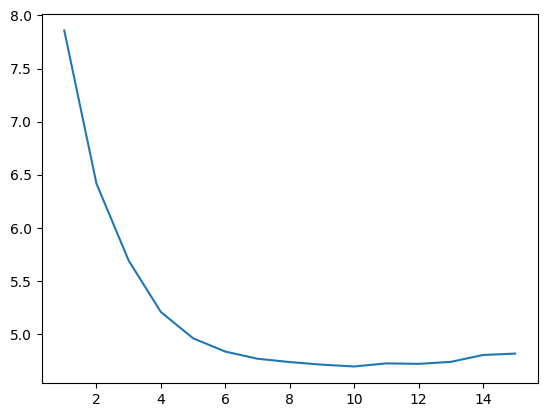

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [27]:
import keras
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### Predicción del próximo caracter

In [28]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [29]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


### Generación de secuencias

In [30]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

#### Se efectúan pruebas con diversos textos de longitud variable

In [33]:
#input_text='como ya hemos dicho, no se h'
#input_text='conservó sin mucho trabajo lo que tanto le h'
#input_text='conservó sin mucho t'
#input_text='no lo consentirían el duque de Milán ni los '
input_text='no lo consentirían el duque de '
generate_seq(model, input_text, max_length=max_context_size, n_words=20)
#generate_seq(model, input_text, max_length=max_context_size, n_words=10)
#generate_seq(model, input_text, max_length=max_context_size, n_words=5)

'no lo consentirían el duque de la milicia de la mil'

### Observación:

- Modelo RNN: Se efectuaron pruebas con diversas partes literales del texto para verificar el comportamiento del modelo. Se encontraron muchos problemas, aunque si bien el texto conformado pareciera conservar cierta lógica sintáctica, no se verifica el mismo resultado evaluando la semántica. Es posible que para un modelo simple implementando tokenización por caracter, las relaciones semánticas no sean capturadas con la misma efectividad que para la sintaxis, donde la combinación de caracteres es lo relevante. Adicionalmente, se probó para diversas n_words, obteniendo resultados similares.

- Modelo LSTM: Se repitieron pruebas respecto al modelo RNN, pero no se observaron grandes diferencias en cuanto a la efectividad del modelo para estimar siguientes letras/palabras. Se probó con diferentes largos de contexto, pero no se verificó un mejor comportamiento. Los altos tiempos de cómputo inherentes al procesamiento, aún con GPU, en Colab resultaron ser un problema en la dinámica de prueba/error. 

- Modelo GRU: Si bien el tiempo de entrenamiento se redujo lo cual facilitó la dinámica del trabajo, se repitieron pruebas pero no se observaron grandes diferencias en cuanto a la efectividad del modelo para estimar las siguientes letras/palabras de la secuencia. Se probó con diferentes largos de contexto, pero no se verificó un mejor comportamiento.

- Se efectuaron pruebas con cadenas de términos obtenidas directamente desde el texto de entrenamiento y no se lograron mejoras significativas en la calidad de la predicción. 

###  Beam search y muestreo aleatorio

In [34]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [35]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

#### Implementación y pruebas con Beam Search

- Mediante la implementación de éste algoritmo se pretede seleccionar las mejores secuencias candidatas a partir de las predicciones actuales, considerando la historia de tokens y probabilidades acumuladas.
- Se efectuaron pruebas para el modo determinístico y para estócastico. 

In [42]:
# predicción con beam search
#salidas = beam_search(model,num_beams=10,num_words=20,input="conservó sin mucho trabajo lo q", mode='sto')
salidas = beam_search(model,num_beams=10,num_words=20,input="conservó sin mucho tr", mode='sto')
#salidas = beam_search(model,num_beams=10,num_words=20,input="conservó sin mucho trabajo lo q", mode='det')
#salidas = beam_search(model,num_beams=5,num_words=20,input="conservó sin mucho trabajo lo q", mode='sto')
#salidas = beam_search(model,num_beams=5,num_words=20,input="conservó sin mucho trabajo lo q", mode='det')
#salidas = beam_search(model,num_beams=10,num_words=10,input="conservó sin mucho trabajo lo q", mode='sto')
#salidas = beam_search(model,num_beams=10,num_words=10,input="habia una vez", mode='det')

In [43]:
salidas[0]

array([27, 32, 48,  3, 24, 49,  9, 53, 51,  3, 13, 48, 51, 54, 12, 27, 22,
       32, 51,  5, 49,  4, 38,  4,  8, 32, 51, 33, 24, 51, 11,  4, 51, 17,
       32, 49,  5, 12, 48,  4,  2])

In [44]:
# veamos las salidas
decode(salidas[0])

'conservó sin mucho trabajo de la fortuna,'